In [14]:
from awpy import DemoParser

demo_parser = DemoParser(demofile="infexample.dem", parse_rate=128)
data = demo_parser.parse(return_type="json")

In [15]:
all_rounds = data["gameRounds"]

In [5]:
ct_full_eco_rounds = [round for round in all_rounds if round["ctBuyType"] == "Full Eco"]
t_full_eco_rounds = [round for round in all_rounds if round["tBuyType"] == "Full Eco"]

In [ ]:
print(len(t_full_eco_rounds))

In [30]:
import numpy as np
t_player_pos = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
# print(t_player_pos)

for round in all_rounds:
    # temp = np.array([])
    for frame in round["frames"]:
        temp = np.array([])
        for t in frame["t"]["players"]:
            temp = np.append(temp, t["x"])
            temp = np.append(temp, t["y"])
        # print(np.expand_dims(temp, axis=0))
        t_player_pos = np.row_stack((t_player_pos, np.expand_dims(temp, axis=0)))
        # print(t_player_pos)


t_player_pos = np.delete(t_player_pos, 0, axis=0)

In [31]:
# from sklearn.preprocessing import MinMaxScaler
# values = t_player_pos.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# values = scaler.fit_transform(values)
MEAN = np.mean(t_player_pos)
STD = np.std(t_player_pos)

data = (t_player_pos - MEAN) / STD
X = data[:-1]
y = data[1:]

In [37]:
ct_player_pos = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
# print(t_player_pos)

for round in all_rounds:
    # temp = np.array([])
    for frame in round["frames"]:
        temp = np.array([])
        for ct in frame["ct"]["players"]:
            temp = np.append(temp, ct["x"])
            temp = np.append(temp, ct["y"])
        # print(np.expand_dims(temp, axis=0))
        ct_player_pos = np.row_stack((ct_player_pos, np.expand_dims(temp, axis=0)))
        # print(t_player_pos)


ct_player_pos = np.delete(ct_player_pos, 0, axis=0)

X = ct_player_pos[:-1]
y = t_player_pos[1:]
# from sklearn.preprocessing import MinMaxScaler
# values = t_player_pos.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# values = scaler.fit_transform(values)
MEAN = np.mean(ct_player_pos)
STD = np.std(ct_player_pos)

data = (ct_player_pos - MEAN) / STD
X = data[:-1]
y = data[1:]

In [38]:
n_points = len(t_player_pos)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

X_train = X_train.reshape(X_train.shape[0], 1, 10)
X_test = X_test.reshape(X_test.shape[0], 1, 10)
print(f"X shape: {X_train.shape}")

We have 489 training points and 243 testing points
X shape: (489, 1, 10)


In [19]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
# from sklearn.preprocessing import MinMaxScaler

tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(1, 10)))
model.add(Dense(10))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                210       
_________________________________________________________________
dense (Dense)                (None, 10)                110       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


In [24]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, 10)))
model.add(Dense(10))
model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
H = model.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
31/31 [==============================] - 0s 962us/step - loss: 0.7273
Epoch 2/100
31/31 [==============================] - 0s 869us/step - loss: 0.7121
Epoch 3/100
31/31 [==============================] - 0s 798us/step - loss: 0.7025
Epoch 4/100
31/31 [==============================] - 0s 771us/step - loss: 0.6966
Epoch 5/100
31/31 [==============================] - 0s 809us/step - loss: 0.6925
Epoch 6/100
31/31 [==============================] - 0s 856us/step - loss: 0.6892
Epoch 7/100
31/31 [==============================] - 0s 830us/step - loss: 0.6868
Epoch 8/100
31/31 [==============================] - 0s 816us/step - loss: 0.6850
Epoch 9/100
31/31 [==============================] - 0s 795us/step - loss: 0.6830
Epoch 10/100
31/31 [==============================] - 0s 836us/step - loss: 0.6814
Epoch 11/100
31/31 [==============================] - 0s 867us/step - loss: 0.6799
Epoch 12/100
31/31 [==============================] - 0s 846us/step - loss: 0.6787
Epoch 13/100


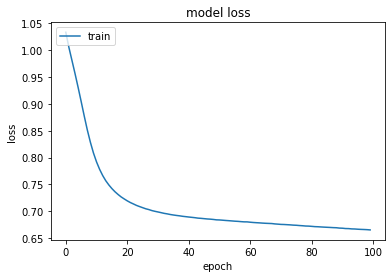

<Figure size 432x288 with 0 Axes>

In [26]:
from matplotlib import pyplot as plt

plt.plot(H.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("loss.png")

In [40]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred = y_train_pred.reshape(X_train.shape[0], 10)
y_test_pred = y_test_pred.reshape(X_test.shape[0], 10)

# data = (t_player_pos - np.mean(t_player_pos)) / np.std(t_player_pos)
# y_train_pred = y_train_pred * np.std(t_player_pos) + np.mean(t_player_pos)
# y_test_pred = y_test_pred * np.std(t_player_pos) + np.mean(t_player_pos)
print(y_train_pred)
from ut import graphpos
for idx, pos in enumerate(y_train_pred):
    graphpos(poses=pos, orig_std=STD, orig_mean=MEAN, show=0, debug=0, filename=r"output/out_" + str(idx) + ".png")
from PIL import Image
import glob

# Create the frames
frames = []
imgs = glob.glob("output/*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif_LTSM_CT.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

[[ 0.66626686  0.8957722   0.8549134  ...  0.6906789   0.7948609
   0.8846336 ]
 [ 0.53113586  0.99712026  0.5058184  ...  0.9716469   0.711628
   1.121347  ]
 [ 0.33387744  0.73763585  0.02453035 ...  0.98864996  0.43602115
   0.89830637]
 ...
 [-0.12752065 -0.51902837 -0.355961   ... -0.51753706 -0.10523936
  -0.5898943 ]
 [ 0.05410711 -0.08989769  0.10136489 ... -0.36651248  0.09599193
  -0.40452582]
 [-0.04273055 -0.45565975  0.0375176  ... -0.53670275 -0.23077136
  -0.30279747]]
